# Trains a diffusion model on CIFAR-10 (version 4).

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

The model is a denoising diffusion probabilistic model (https://arxiv.org/abs/2006.11239), which is trained to reverse a gradual noising process, allowing the model to generate samples from the learned data distribution starting from random noise. DDIM-style deterministic sampling (https://arxiv.org/abs/2010.02502) is also supported. This model is also trained on continuous timesteps. It uses the 'v' objective from Progressive Distillation for Fast Sampling of Diffusion Models (https://openreview.net/forum?id=TIdIXIpzhoI). It is usable for classifier-free diffusion guidance (https://openreview.net/forum?id=qw8AKxfYbI).

In [2]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [3]:
# Check the GPU type

!nvidia-smi

Wed Dec 11 23:57:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   27C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [5]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [6]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, is_last=False):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if not is_last else nn.Identity(),
            nn.ReLU(inplace=True) if not is_last else nn.Identity(),
        ], skip)


class SelfAttention2d(nn.Module):
    def __init__(self, c_in, n_head=1, dropout_rate=0.1):
        super().__init__()
        assert c_in % n_head == 0
        self.norm = nn.GroupNorm(1, c_in)
        self.n_head = n_head
        self.qkv_proj = nn.Conv2d(c_in, c_in * 3, 1)
        self.out_proj = nn.Conv2d(c_in, c_in, 1)
        self.dropout = nn.Dropout2d(dropout_rate, inplace=True)

    def forward(self, input):
        n, c, h, w = input.shape
        qkv = self.qkv_proj(self.norm(input))
        qkv = qkv.view([n, self.n_head * 3, c // self.n_head, h * w]).transpose(2, 3)
        q, k, v = qkv.chunk(3, dim=1)
        scale = k.shape[3]**-0.25
        att = ((q * scale) @ (k.transpose(2, 3) * scale)).softmax(3)
        y = (att @ v).transpose(2, 3).contiguous().view([n, c, h, w])
        return input + self.dropout(self.out_proj(y))


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)
        self.class_embed = nn.Embedding(11, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        SelfAttention2d(c * 4, c * 4 // 64),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    SelfAttention2d(c * 2, c * 2 // 64),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, is_last=True),
        )

    def forward(self, input, t, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [7]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)





The noise schedule:


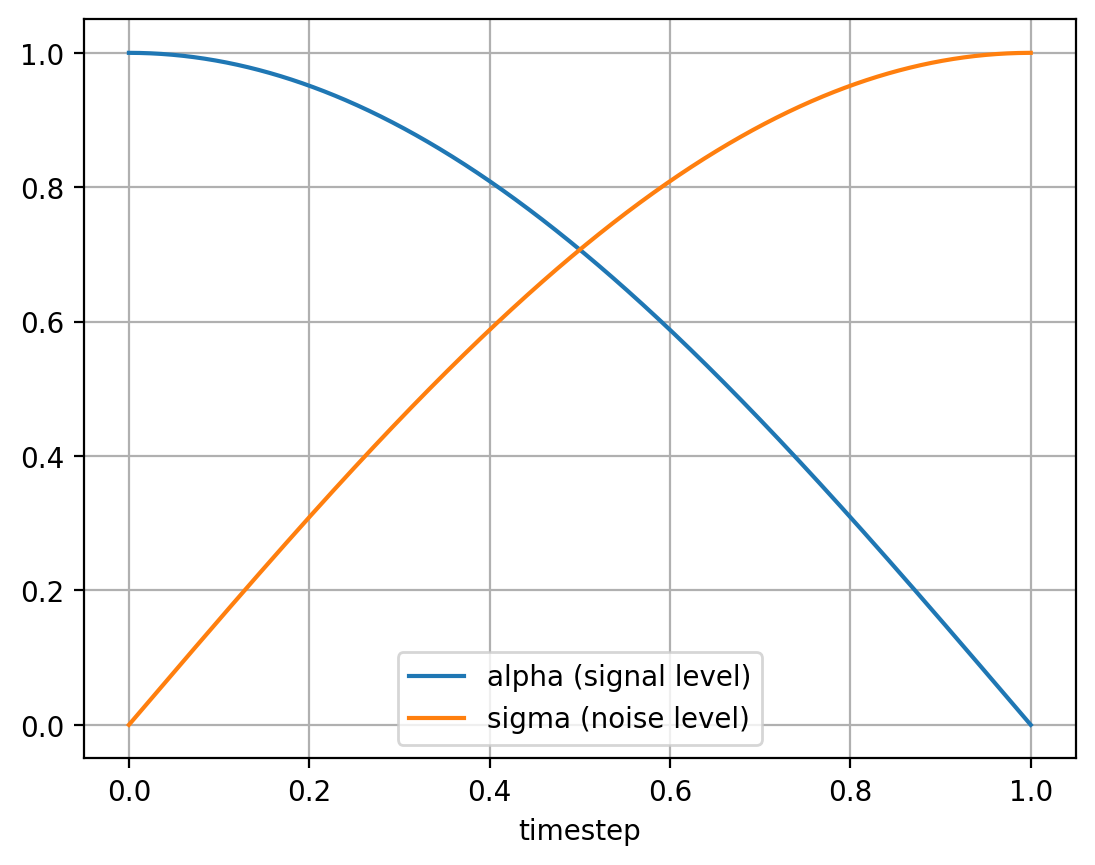

In [8]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
alphas_vis, sigmas_vis = get_alphas_sigmas(t_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [9]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 27487287


In [ ]:
# Actually train the model

ema_decay = 0.999

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.

# Classifier-free guidance scale (0 is unconditional, 1 is conditional)
guidance_scale = 2.

def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    alphas, sigmas = get_alphas_sigmas(t)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Drop out the class on 20% of the examples
    to_drop = torch.rand(classes.shape, device=classes.device).le(0.2)
    classes_drop = torch.where(to_drop, -torch.ones_like(classes), classes)

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, t, classes_drop)
        return F.mse_loss(v, targets)


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
def sample(model, x, steps, eta, classes, guidance_scale=1.):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            x_in = torch.cat([x, x])
            ts_in = torch.cat([ts, ts])
            classes_in = torch.cat([-torch.ones_like(classes), classes])
            v_uncond, v_cond = model(x_in, ts_in * t[i], classes_in).float().chunk(2)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred

@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    demo()
    while True:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 5 == 0:
            val()
            demo()
        save()
except KeyboardInterrupt:
    pass


Loaded model from epoch 102

Sampling...


/home/zzding/anaconda3/envs/DPS/lib/python3.8/site-packages/torch/random.py:99: UserWarning: CUDA reports that you have 4 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

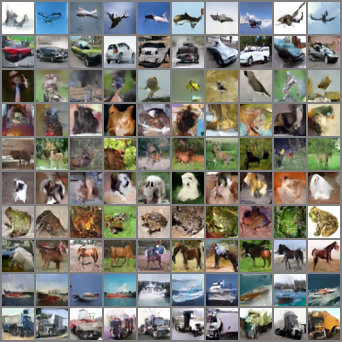

In [ ]:
model.load_state_dict(torch.load('cifar_diffusion.pth')['model'])
model_ema.load_state_dict(torch.load('cifar_diffusion.pth')['model_ema'])
opt.load_state_dict(torch.load('cifar_diffusion.pth')['opt'])
scaler.load_state_dict(torch.load('cifar_diffusion.pth')['scaler'])
epoch = torch.load('cifar_diffusion.pth')['epoch']
print('Loaded model from epoch', epoch)
demo()

In [ ]:

class MotionBlur(nn.Module):
    def __init__(self, kernel_size=15, angle=0):
        super(MotionBlur, self).__init__()
        
        self.kernel_size = kernel_size
        self.angle = torch.tensor(angle * np.pi / 180) 
        
        self.register_buffer('kernel', self._create_kernel())
        
    def _create_kernel(self):
        kernel = torch.zeros((self.kernel_size, self.kernel_size))
        center = self.kernel_size // 2
        
        cos_val = torch.cos(self.angle)
        sin_val = torch.sin(self.angle)
        
        for i in range(self.kernel_size):
            offset = i - center
            x = int(offset * cos_val)
            y = int(offset * sin_val)
            if abs(x) < self.kernel_size//2 and abs(y) < self.kernel_size//2:
                kernel[center + y, center + x] = 1
                
        kernel = kernel / kernel.sum()
        
        return kernel.view(1, 1, self.kernel_size, self.kernel_size)
    
    def forward(self, x):

        if not x.is_floating_point():
            x = x.float()
        
        kernel = self.kernel.repeat(x.size(1), 1, 1, 1)
        
        pad = self.kernel_size // 2
        out = F.conv2d(x, kernel, padding=pad, groups=x.size(1))
        
        return out

    
class DownSample(nn.Module):
    def __init__(self, scale=0.5, mode='bilinear'):
        super(DownSample, self).__init__()
        self.scale = scale
        self.mode = mode
        
    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale, 
                           mode=self.mode, 
                           align_corners=True)
        
        
class GaussianBlur(nn.Module):
    def __init__(self, kernel_size=15, sigma=3):
        super(GaussianBlur, self).__init__()
        
        self.kernel_size = kernel_size
        self.sigma = sigma
        
        self.register_buffer('kernel', self._create_gaussian_kernel())
        
    def _create_gaussian_kernel(self):

        center = self.kernel_size // 2
        x = torch.arange(self.kernel_size) - center
        x = x.float()
        
        gaussian_1d = torch.exp(-0.5 * (x / self.sigma)**2)
        gaussian_1d = gaussian_1d / gaussian_1d.sum()
        
        gaussian_2d = gaussian_1d.view(1, -1) * gaussian_1d.view(-1, 1)
        gaussian_2d = gaussian_2d / gaussian_2d.sum()
        
        return gaussian_2d.view(1, 1, self.kernel_size, self.kernel_size)
    
    def forward(self, x):
        if not x.is_floating_point():
            x = x.float()
        
        kernel = self.kernel.repeat(x.size(1), 1, 1, 1)
        
        pad = self.kernel_size // 2
        out = F.conv2d(x, kernel.to(x.device), padding=pad, groups=x.size(1))
        
        return out
    
class Inpainting(nn.Module):
    def __init__(self, mask=None, mask_mode='random', mask_ratio=0.5, mask_size=32):
        super(Inpainting, self).__init__()
        
        self.mask_mode = mask_mode
        self.mask_ratio = mask_ratio
        self.mask_size = mask_size
        
        if mask is not None:
            self.register_buffer('mask', mask)
        else:
            self.mask = None
            
    def _create_random_mask(self, shape):
        
        b, c, h, w = shape
        mask = torch.rand(b, 1, h, w) > self.mask_ratio
        self.mask = mask
        return mask.float()
    
    def _create_center_mask(self, shape):
        b, c, h, w = shape
        mask = torch.ones(b, 1, h, w)
        
        # 计算中心区域
        center_h = h // 2
        center_w = w // 2
        mask_h = self.mask_size
        mask_w = self.mask_size
        
        h_start = center_h - mask_h // 2
        h_end = h_start + mask_h
        w_start = center_w - mask_w // 2
        w_end = w_start + mask_w
        
        mask[:, :, h_start:h_end, w_start:w_end] = 0
        return mask
        
    def get_mask(self, x):
        if self.mask is not None:
            return self.mask.to(x.device)
        elif self.mask_mode == 'random':
            return self._create_random_mask(x.shape).to(x.device)
        elif self.mask_mode == 'center':
            return self._create_center_mask(x.shape).to(x.device)
        else:
            raise ValueError(f"Unsupported mask mode: {self.mask_mode}")
    
    def forward(self, x):
        if not x.is_floating_point():
            x = x.float()
            
        mask = self.get_mask(x)
        mask = mask.repeat(1, x.size(1), 1, 1)
        
        return x * mask

  0%|          | 0/10 [00:00<?, ?it/s]


Sampling...


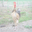

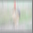

  0%|          | 0/500 [00:00<?, ?it/s]

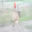



Sampling...


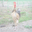

  0%|          | 0/500 [00:00<?, ?it/s]

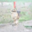



Sampling...


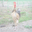

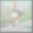

  0%|          | 0/500 [00:00<?, ?it/s]

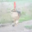



Sampling...


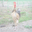

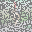

  0%|          | 0/500 [00:00<?, ?it/s]

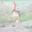



Sampling...


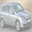

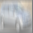

  0%|          | 0/500 [00:00<?, ?it/s]

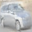



Sampling...


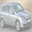

  0%|          | 0/500 [00:00<?, ?it/s]

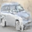



Sampling...


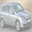

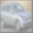

  0%|          | 0/500 [00:00<?, ?it/s]

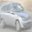



Sampling...


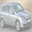

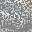

  0%|          | 0/500 [00:00<?, ?it/s]

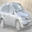



Sampling...


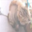

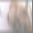

  0%|          | 0/500 [00:00<?, ?it/s]

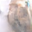



Sampling...


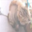

  0%|          | 0/500 [00:00<?, ?it/s]

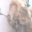



Sampling...


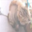

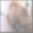

  0%|          | 0/500 [00:00<?, ?it/s]

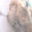



Sampling...


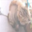

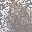

  0%|          | 0/500 [00:00<?, ?it/s]

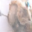



Sampling...


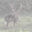

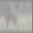

  0%|          | 0/500 [00:00<?, ?it/s]

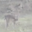



Sampling...


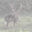

  0%|          | 0/500 [00:00<?, ?it/s]

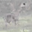



Sampling...


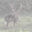

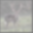

  0%|          | 0/500 [00:00<?, ?it/s]

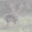



Sampling...


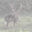

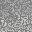

  0%|          | 0/500 [00:00<?, ?it/s]

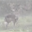



Sampling...


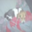

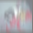

  0%|          | 0/500 [00:00<?, ?it/s]

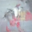



Sampling...


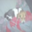

  0%|          | 0/500 [00:00<?, ?it/s]

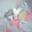



Sampling...


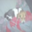

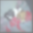

  0%|          | 0/500 [00:00<?, ?it/s]

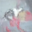



Sampling...


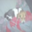

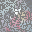

  0%|          | 0/500 [00:00<?, ?it/s]

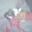



Sampling...


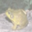

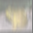

  0%|          | 0/500 [00:00<?, ?it/s]

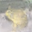



Sampling...


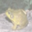

  0%|          | 0/500 [00:00<?, ?it/s]

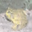



Sampling...


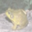

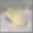

  0%|          | 0/500 [00:00<?, ?it/s]

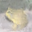



Sampling...


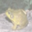

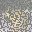

  0%|          | 0/500 [00:00<?, ?it/s]

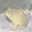



Sampling...


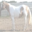

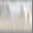

  0%|          | 0/500 [00:00<?, ?it/s]

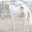



Sampling...


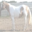

  0%|          | 0/500 [00:00<?, ?it/s]

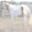



Sampling...


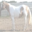

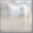

  0%|          | 0/500 [00:00<?, ?it/s]

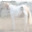



Sampling...


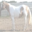

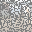

  0%|          | 0/500 [00:00<?, ?it/s]

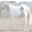



Sampling...


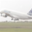

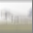

  0%|          | 0/500 [00:00<?, ?it/s]

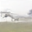



Sampling...


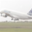

  0%|          | 0/500 [00:00<?, ?it/s]

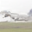



Sampling...


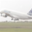

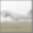

  0%|          | 0/500 [00:00<?, ?it/s]

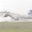



Sampling...


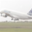

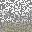

  0%|          | 0/500 [00:00<?, ?it/s]

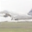



Sampling...


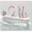

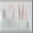

  0%|          | 0/500 [00:00<?, ?it/s]

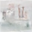



Sampling...


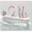

  0%|          | 0/500 [00:00<?, ?it/s]

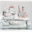



Sampling...


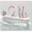

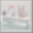

  0%|          | 0/500 [00:00<?, ?it/s]

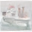



Sampling...


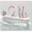

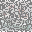

  0%|          | 0/500 [00:00<?, ?it/s]

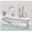



Sampling...


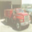

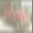

  0%|          | 0/500 [00:00<?, ?it/s]

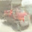



Sampling...


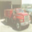

  0%|          | 0/500 [00:00<?, ?it/s]

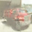



Sampling...


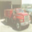

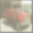

  0%|          | 0/500 [00:00<?, ?it/s]

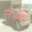



Sampling...


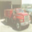

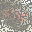

  0%|          | 0/500 [00:00<?, ?it/s]

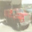

In [ ]:
import numpy as np
@torch.enable_grad()
def dps_sample(model, x, steps, eta, classes, guidance_scale=1., y_0=None, A=None, zeta=0.1):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    for i in trange(steps):
        x = x.detach().requires_grad_()
        with torch.cuda.amp.autocast():
            x_in = torch.cat([x, x])
            ts_in = torch.cat([ts, ts])
            classes_in = torch.cat([-torch.ones_like(classes), classes])
            v_uncond, v_cond = model(x_in, ts_in * t[i], classes_in).float().chunk(2)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x_temp = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x_temp += torch.randn_like(x) * ddim_sigma
                
        if A is not None and y_0 is not None:
            measurement_error = y_0 - A(pred)
            
            loss = torch.norm(measurement_error, p=2) ** 2
            grad = torch.autograd.grad(loss, x)[0]
            x_temp = x_temp - zeta * grad
            
        x = x_temp

    return pred

import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image

def down_sample(input, scale=0.5):
    return F.interpolate(input, scale_factor=scale, mode='bilinear', align_corners=True)

def dps(A, label):
    tqdm.write('\nSampling...')
    seed = 0
    torch.manual_seed(seed)

    x_0_dir = f"ground_truth/{label}.png"
    x_0_image = Image.open(x_0_dir)
    transform = transforms.ToTensor()
    x_0 = transform(x_0_image).unsqueeze(0).to(device)
    y_0 = A(x_0)

    # #展示x_0
    grid = utils.make_grid(x_0, 1).cpu()
    filename = f'tmp/demo_x_0.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    
    #展示y_0
    grid = utils.make_grid(y_0, 1).cpu()
    filename = f'tmp/demo_y_0.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    
    noise = torch.randn([1, 3, 32, 32], device=device)
    fakes_classes = torch.full((1,), -1, device=device).repeat_interleave(1, 0)
    guidance_scale = 0
    hat_x_0 = dps_sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale, y_0, A, zeta)
    
    grid = utils.make_grid(hat_x_0, 1).cpu()
    filename = f'tmp/demo_hat_x_0.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))

    tqdm.write('')
    return x_0, y_0, hat_x_0

import os
labels = ['bird', 'car', 'cat', 'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck']
actions = ['motion_blur', 'super_resolution', 'gaussian_blur', 'inpainting']

for label in tqdm(labels):
    for action in actions:
        if(action == 'motion_blur'):
            A = MotionBlur(kernel_size=8, angle=90).cuda() 
            zeta = 0.1
        elif(action == 'super_resolution'):
            A = DownSample(scale=0.5).cuda()
            zeta = 1
        elif(action == 'gaussian_blur'):
            A = GaussianBlur(kernel_size=8, sigma=1).cuda()
            zeta = 0.1
        elif(action == 'inpainting'):
            A = Inpainting(mask_mode='random', mask_size=16).cuda()
            zeta = 0.1
        x_0, y_0, hat_x_0 = dps(A, label)
        output_dir = f"results/{action}"
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        label_dir = f"{output_dir}/label"
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        grid = utils.make_grid(x_0, 1).cpu()
        filename = f'{label_dir}/{label}.png'
        TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)   
        
        input_dir = f"{output_dir}/input"
        if not os.path.exists(input_dir):
            os.makedirs(input_dir)
        grid = utils.make_grid(y_0, 1).cpu()
        filename = f'{input_dir}/{label}.png'
        TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
        
        recon_dir = f"{output_dir}/recon"
        if not os.path.exists(recon_dir):
            os.makedirs(recon_dir)
        grid = utils.make_grid(hat_x_0, 1).cpu()
        filename = f'{recon_dir}/{label}.png'
        TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    

/tmp/ipykernel_1485525/1985981342.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


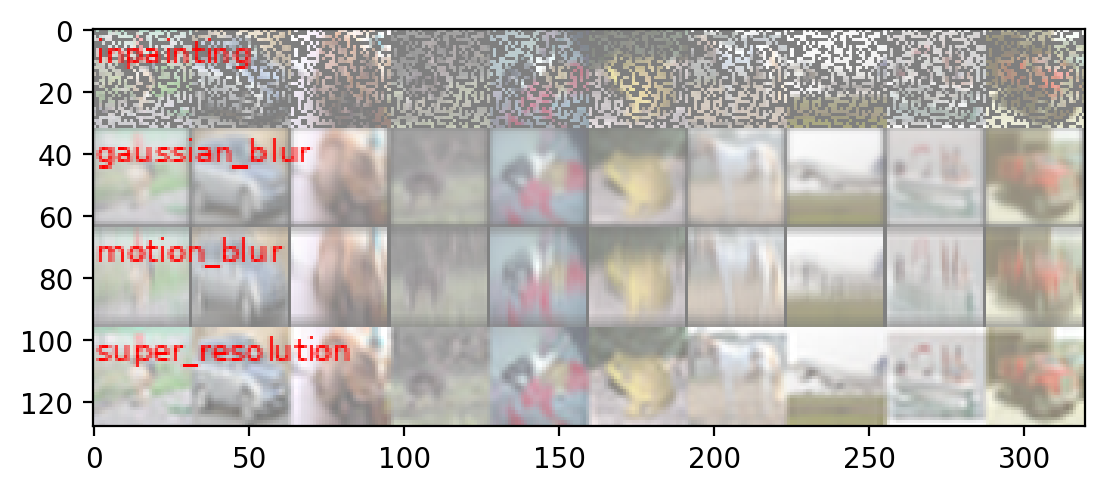

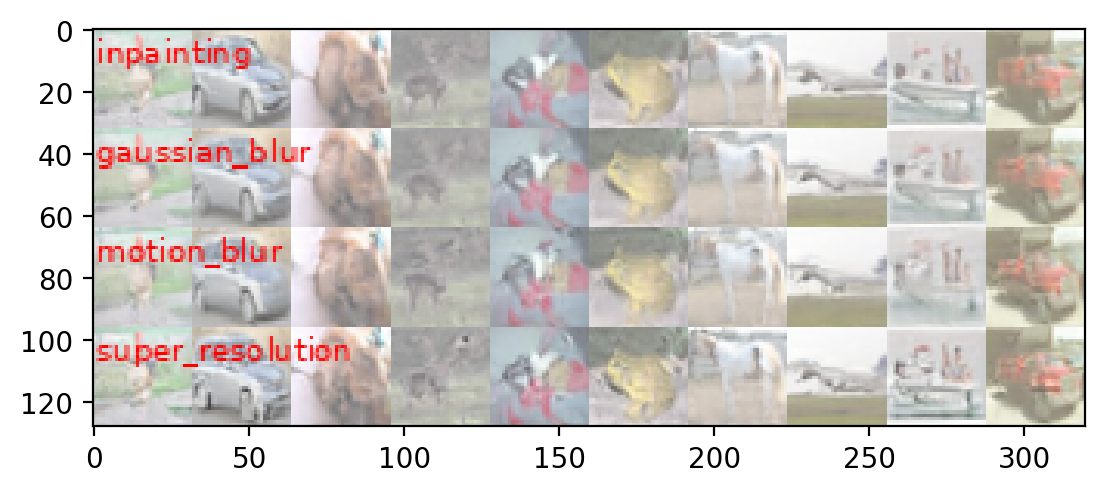

In [39]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def resize_image_with_pil(image_array, target_size):
    image = Image.fromarray(image_array)
    resized_image = image.resize(target_size, Image.ANTIALIAS)
    resized_image_array = np.array(resized_image)
    return resized_image_array

def add_text_to_image(image_array, text, position=(1, 1), font_size=20):
    image = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    draw.text(position, text, font=font, fill=(255, 0, 0))
    image_array_with_text = np.array(image)
    return image_array_with_text

def save_image(image_array, filename):
    image = Image.fromarray(image_array)
    image.save(filename)
    
result_dir = "results"
methods = os.listdir(result_dir)
labels = ['bird', 'car', 'cat', 'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck']

image_list = [f'{i}.png' for i in labels]
images = []
total_input_images = []
total_output_images = []
for m in methods[:]:
    input_dir = os.path.join(result_dir, m, "input")
    input_images = []
    for image_dir in image_list:
        image_path = os.path.join(input_dir, image_dir)
        image = Image.open(image_path)
        image_array = np.array(image)
        input_images.append(image_array)
    
    
    recon_dir = os.path.join(result_dir, m, "recon")
    recon_images = []
    for image_dir in image_list:
        image_path = os.path.join(recon_dir, image_dir)
        image = Image.open(image_path)
        image_array = np.array(image)
        recon_images.append(image_array)
        
    input_images = np.concatenate(input_images, axis=1)
    recon_images = np.concatenate(recon_images, axis=1)
    if(input_images.shape[0] != recon_images.shape[0]):
        input_images = resize_image_with_pil(input_images, (recon_images.shape[1], recon_images.shape[0]))
   
 
    input_images = add_text_to_image(input_images, m, font_size=10)
    recon_images = add_text_to_image(recon_images, m, font_size=10)
    

    total_input_images.append(input_images)
    total_output_images.append(recon_images)
    
total_input_image = np.concatenate(total_input_images, axis=0)
total_output_image = np.concatenate(total_output_images, axis=0)

save_image(total_input_image, "cifar10_input_image.png")
save_image(total_output_image, "cifar10_output_image.png")

plt.imshow(total_input_image)
plt.show()
plt.imshow(total_output_image)
plt.show()

In [40]:
result_dir = "results"
methods = os.listdir(result_dir)
labels = ['bird', 'car', 'cat', 'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck']
image_list = [f'{i}.png' for i in labels]
images = []
total_input_images = []
total_output_images = []
for m in methods[0:1]:
    label_dir = os.path.join(result_dir, m, "label")
    label_images = []
    for image_dir in image_list:
        image_path = os.path.join(label_dir, image_dir)
        image = Image.open(image_path)
        image_array = np.array(image)
        label_images.append(image_array)
    label_image = np.concatenate(label_images, axis=1)
    save_image(label_image, "cifar10_label_image.png")